# `2.1 Selection`

0. Libraries and constants
1. Feature filtering
2. Univariate analysis

## 2.0 Libraries and constants

In [1]:
# Libraries
import pandas as pd

## 2.1 Feature filtering
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Constants
FORMATTED_TABLE_PATH = 'data/processed-data/1-formatted-table.csv'
DTYPES_PATH = 'data/metadata/columns.csv'
POSSIBLY_NULL_CLASSES_PATH = 'data/metadata/possibly-null-classes.csv'

# Load
FORMATTED_TABLE = pd.read_csv(
    FORMATTED_TABLE_PATH,
    header=[0, 1]
)
DTYPES = pd.read_csv(DTYPES_PATH, index_col=0).dtype
POSSIBLY_NULL_CLASSES = pd.read_csv(POSSIBLY_NULL_CLASSES_PATH)

In [3]:
# Data frame
german_credit_data = FORMATTED_TABLE.copy()

for (column, _description) in german_credit_data.columns:
    german_credit_data[column] = german_credit_data[column].astype(DTYPES[column])

## 2.1 Feature filtering

> MARKOV, Anton; SELEZNYOVA, Zinaida; LAPSHIN, Victor. **`Credit scoring methods: Latest trends and points to consider.`** The Journal of Finance and Data Science, v. 8, p. 180-201, 2022.

> DOI: 10.1016/j.jfds.2022.07.002. Available at: https://doi.org/10.1016/j.jfds.2022.07.002. Access on: 6 ago. 2025.

**Drop** feature which have more than:
- 30% of their values missing.
- 99% of their values concentrated in a single category or value.

### Before filtering
There are some classes that actually represent null values.

In [4]:
# Nullify classes that are actually encoded nulls

## For each class_label in POSSIBLY_NULL_CLASSES_PATH,
## nullify the values in its respective german_credit_data[column],
## where column is the column_label in POSSIBLY_NULL_CLASSES.

for class_label in POSSIBLY_NULL_CLASSES.class_label:
    '''
    class_label: str
    '''
    
    # 1 Get the column multiindex key for this class_label
    
    ## rows contain: column_label, column_description, class_label, class_description
    row = POSSIBLY_NULL_CLASSES.loc[
        POSSIBLY_NULL_CLASSES.class_label == class_label
    ].squeeze()
    
    ## Use only column_label and column_description to form the multiindex key
    column_key = (row.column_label, row.column_description)
    
    # 2 Map the possibly null class to np.nan
    nullifier_map = {class_label: pd.NA}

    # 3 Replace according to the map
    german_credit_data[column_key] = german_credit_data[column_key].replace(nullifier_map)


/var/folders/jv/p79syq_s36q174w0t4bgswnr0000gn/T/ipykernel_12826/3837483422.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  german_credit_data[column_key] = german_credit_data[column_key].replace(nullifier_map)


In [5]:
# Test if the result mantains statistical properties

# For each class_label in POSSIBLY_NULL_CLASSES.class_label,
# check if the number of nulls in german_credit_data[column_key] is equal to the
# number of rows in POSSIBLY_NULL_CLASSES where class_label is the same.

for class_label in POSSIBLY_NULL_CLASSES.class_label:
    '''
    class_label: str
    '''
    
    # 1 Get the column multiindex key for this class_label
    
    ## rows contain: column_label, column_description, class_label, class_description
    row = POSSIBLY_NULL_CLASSES.loc[
        POSSIBLY_NULL_CLASSES.class_label == class_label
    ].squeeze()

    ## Use only column_label and column_description to form the multiindex key
    column_key = (row.column_label, row.column_description)
    
    # 2 Get the number of nulls in german_credit_data[column_key]
    num_nulls = german_credit_data[column_key].isna().sum()
    
    # 3 Get the number of rows in FORMATTED_TABLE where the value is the class_label itself
    num_rows = FORMATTED_TABLE.loc[
        FORMATTED_TABLE[column_key] == class_label
    ].shape[0]
    
    # 4 Assert that the number of nulls is equal to the number of rows
    assert num_nulls == num_rows, (
        f'Number of nulls in {column_key} ({num_nulls}) does not match the number of rows in POSSIBLY_NULL_CLASSES ({num_rows}) for class_label {class_label}.'
    )


### a) 30% of their values missing.

Column | Class | Representativeness
--- | --- | --- 
A1, Status of existing checking account | A14: No checking account | 39%
A10, Other debtors / guarantors | A101: None | 91%
A14, Other installment plans | A143: None | 81%

In [6]:
# Get missing counts per column
missing_counts = german_credit_data.isnull().sum()

/var/folders/jv/p79syq_s36q174w0t4bgswnr0000gn/T/ipykernel_12826/3568009180.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = german_credit_data.shape[0] - missing_counts[i]


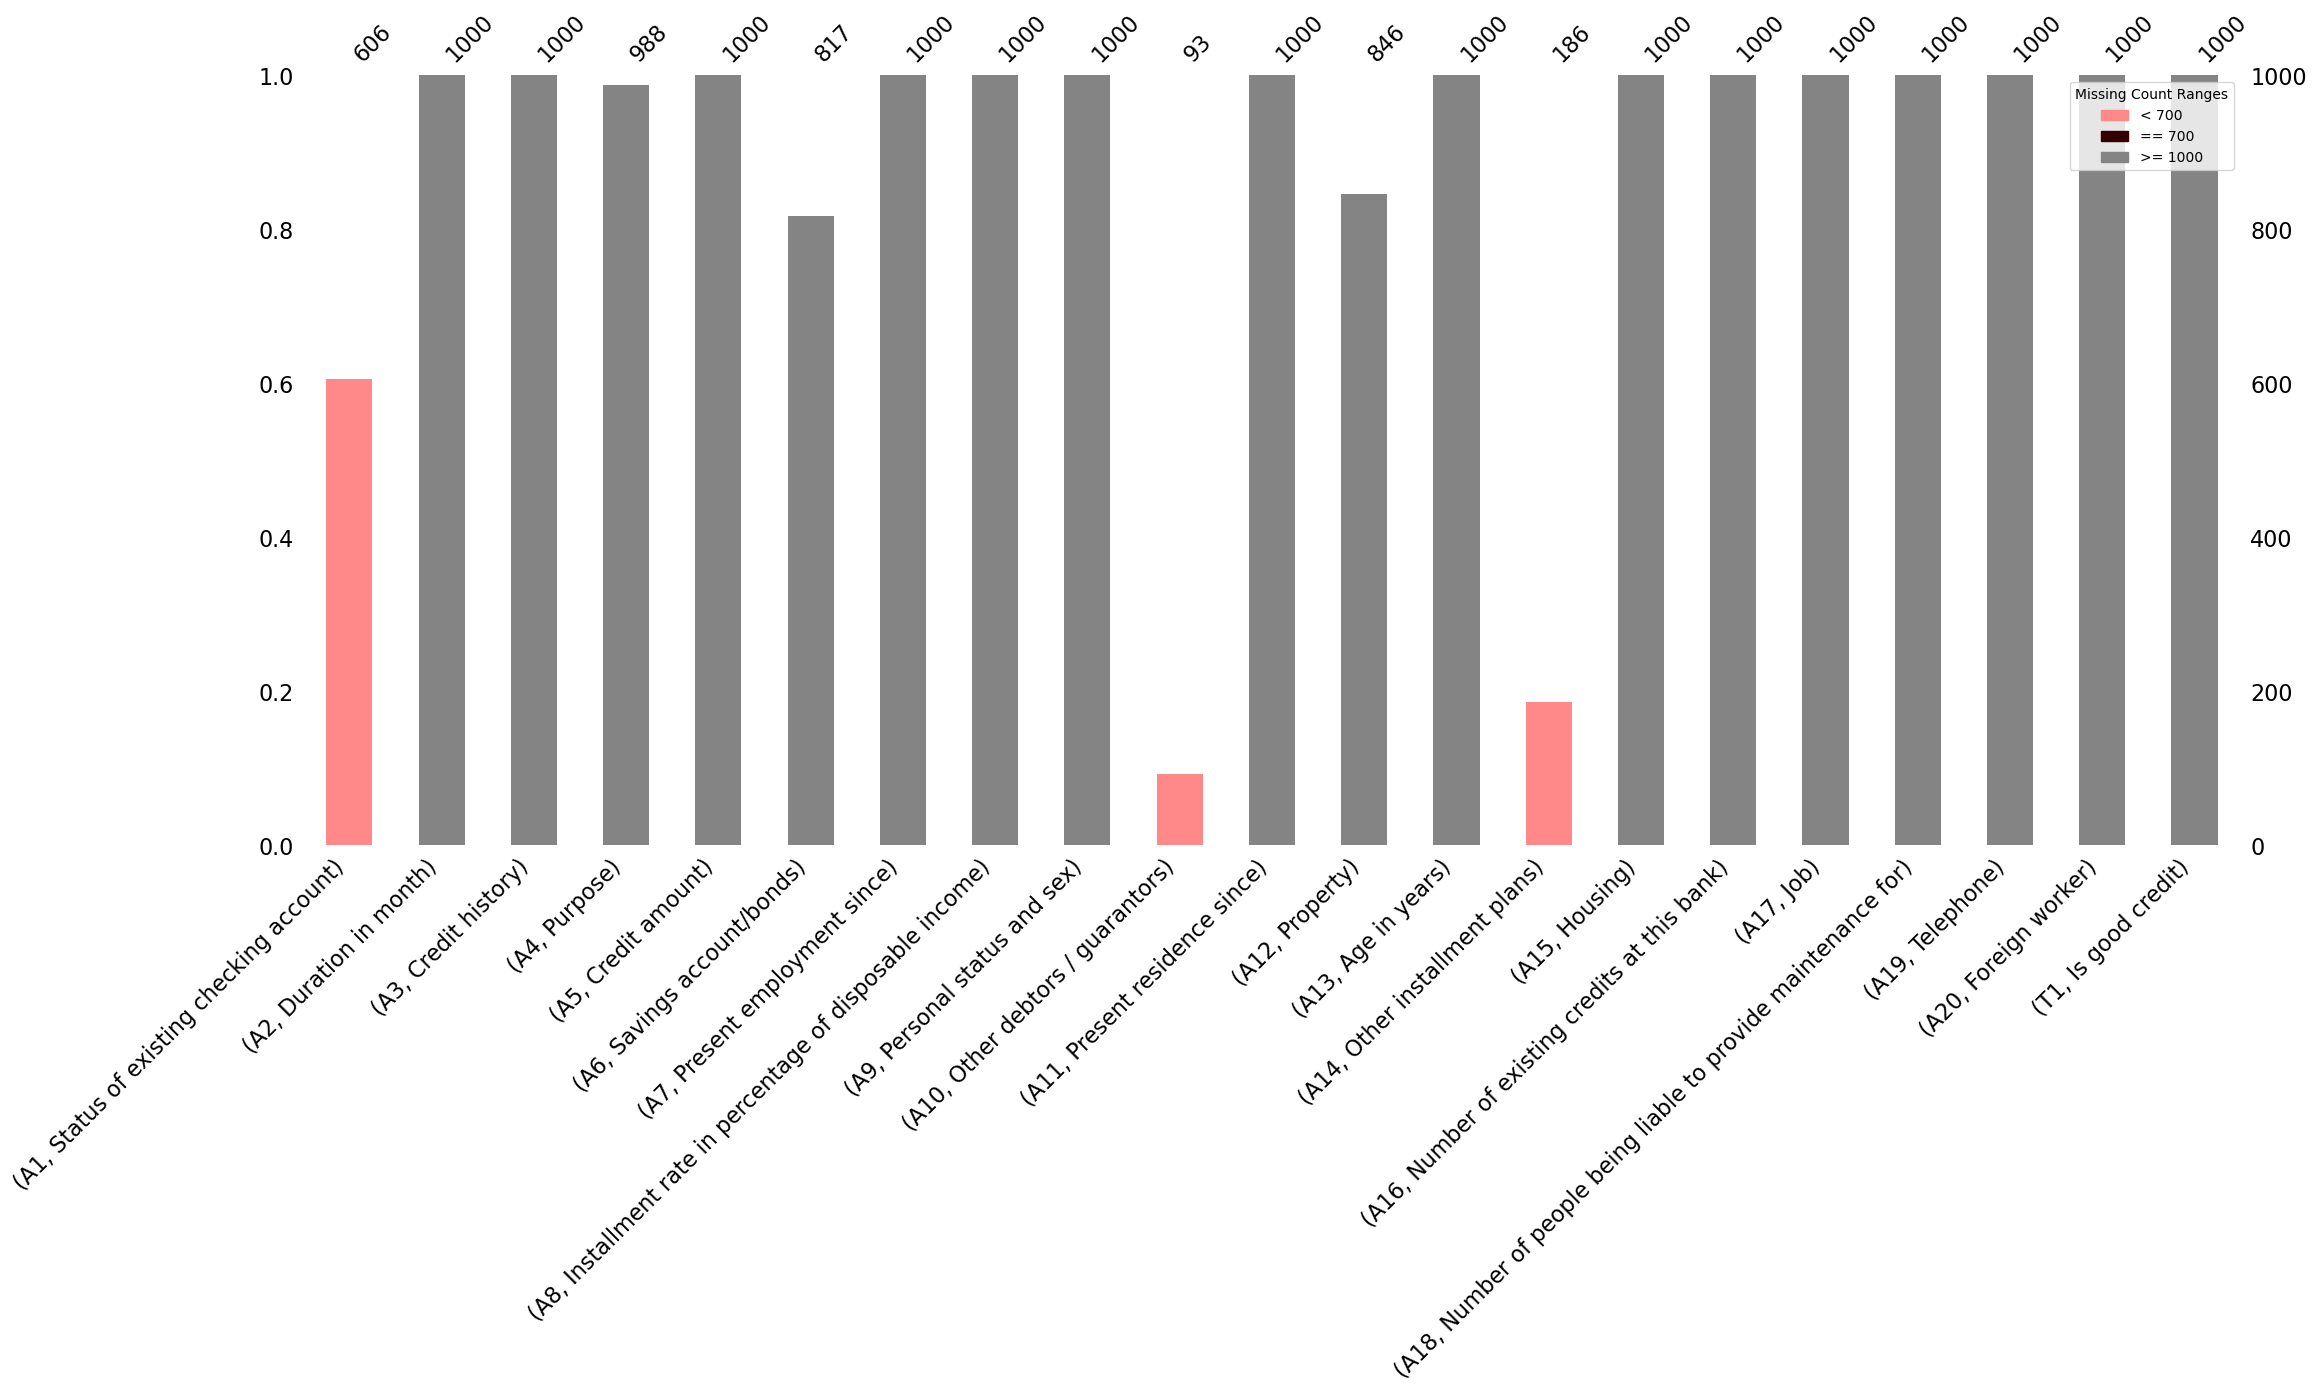

In [7]:
# Missingno bar plot
ax = msno.bar(german_credit_data, color='grey')

# Tint bars with different red accents based on count
for i, p in enumerate(ax.patches):
    count = german_credit_data.shape[0] - missing_counts[i]
    if count <= 700:
        p.set_facecolor("#ff8989")
    elif count == 700:
        p.set_facecolor("#330000")
    else:
        p.set_facecolor("#848484FF")
        
# add legend
plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color="#ff8989", label="< 700"),
        plt.Rectangle((0, 0), 1, 1, color="#330000", label="== 700"),
        plt.Rectangle((0, 0), 1, 1, color="#848484FF", label=">= 1000")
    ],
    loc='upper right',
    title='Missing Count Ranges'
)

<Axes: >

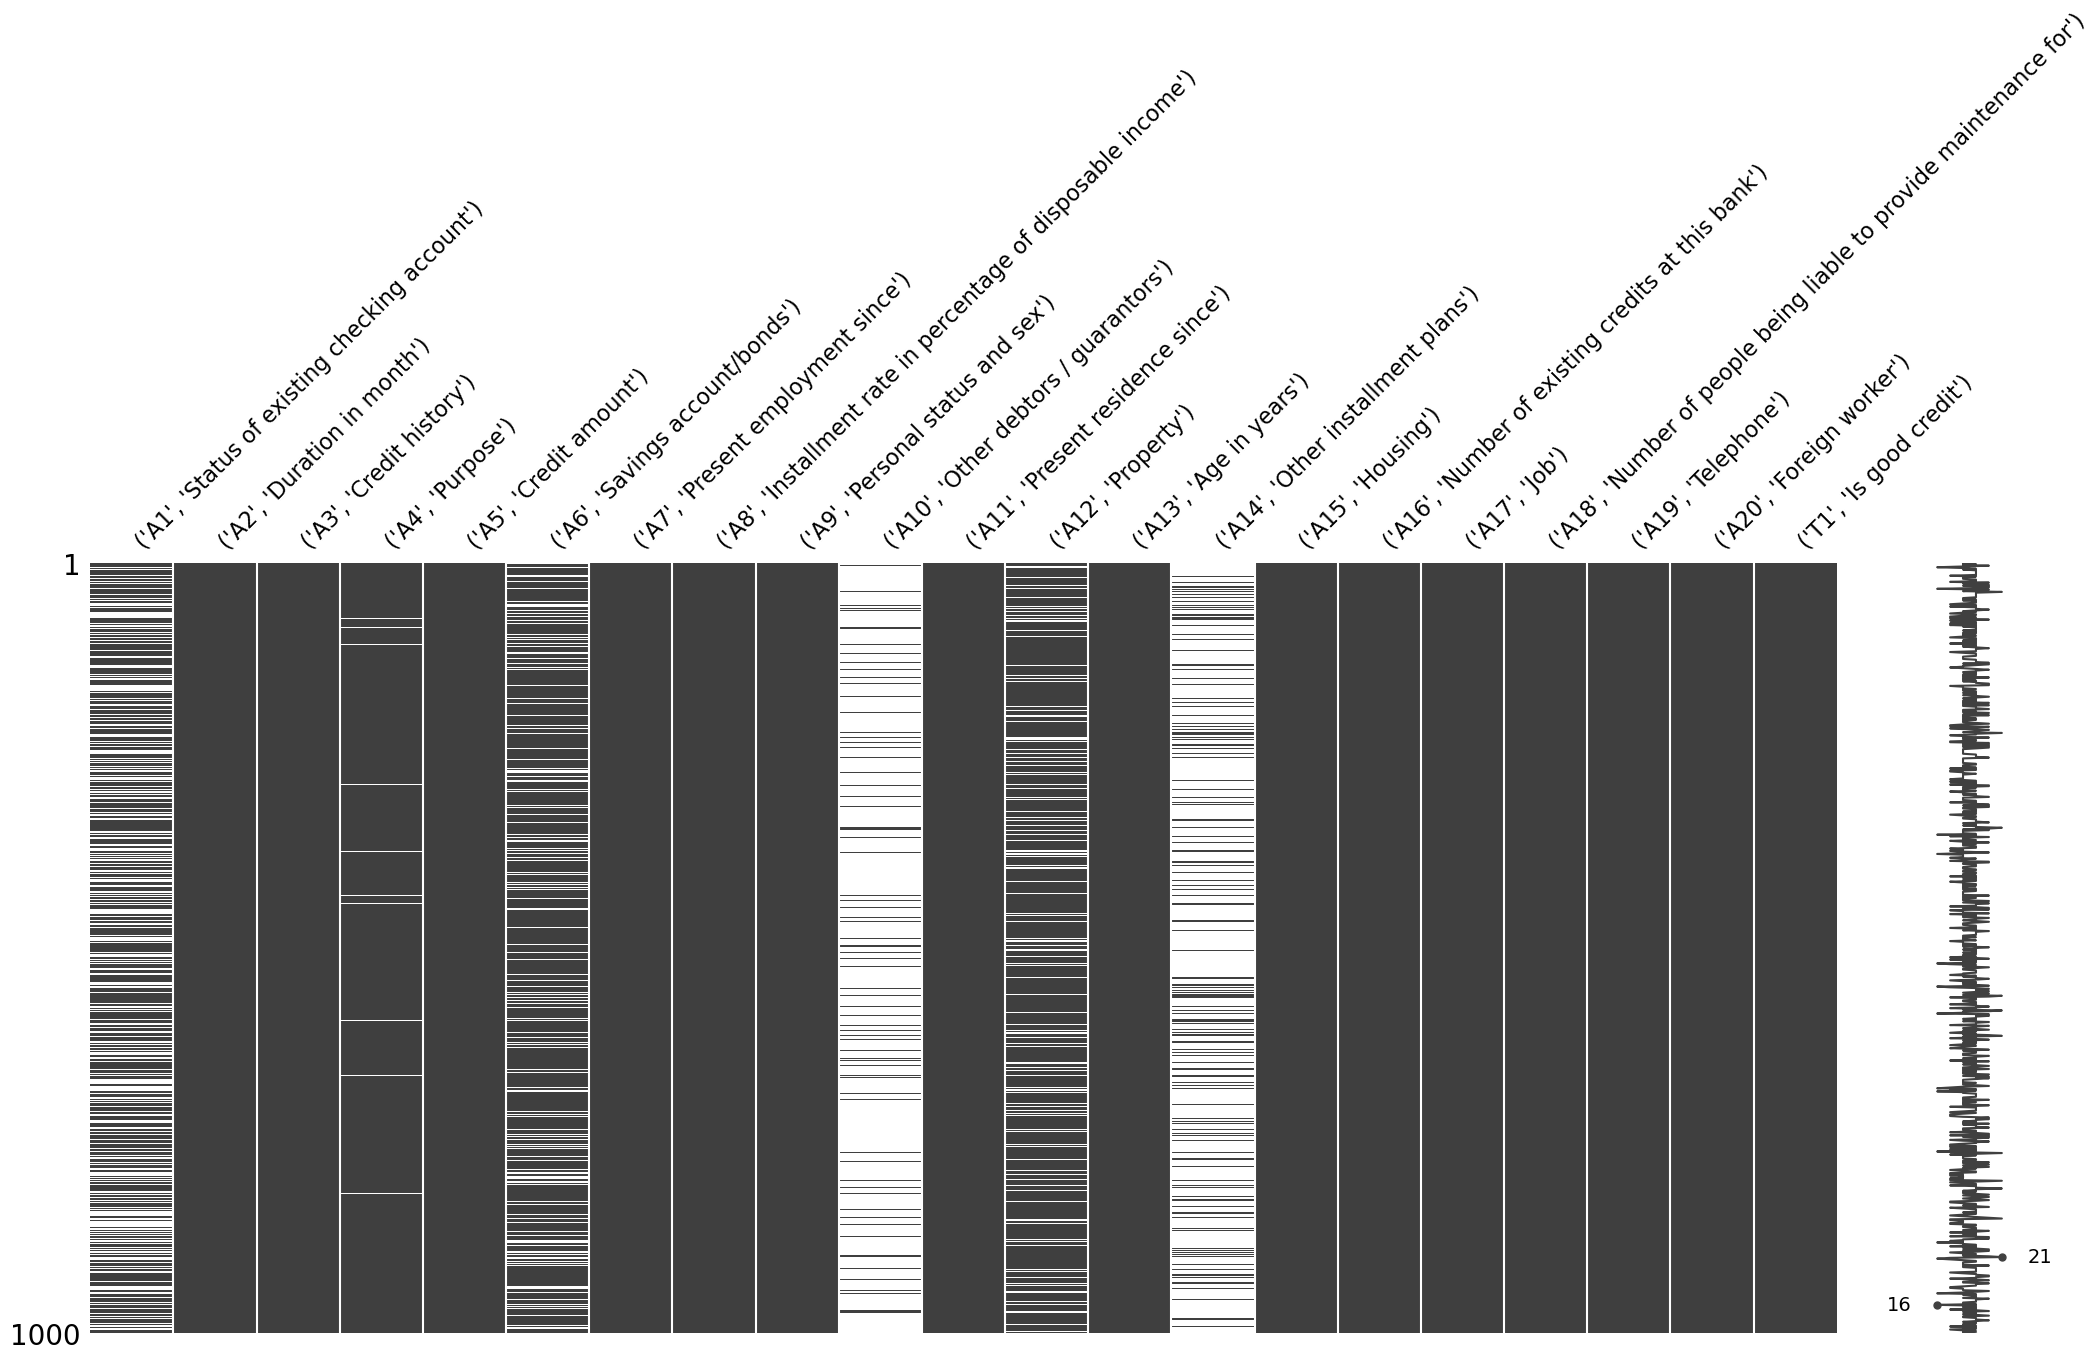

In [8]:
# Missingno matrix plot
msno.matrix(german_credit_data)

In [9]:
# Drop A1, A10, and A14 columns

columns_to_drop = [
    ('A1', 'Status of existing checking account'),
    ('A10', 'Other debtors / guarantors'),
    ('A14', 'Other installment plans')
]

german_credit_data = german_credit_data.drop(
    columns=[
        (column, description) for (column, description) in columns_to_drop
    ]
)

In [14]:
# Assert that only the three columns were dropped
original_columns = set(FORMATTED_TABLE.columns)
remaining_colums = set(german_credit_data.columns)

dropped_columns = original_columns - remaining_colums

assert len(dropped_columns) == 3, (
    f'Expected 3 columns after dropping, but got {len(dropped_columns)}.'
    f' Remaining columns: {dropped_columns}'
)

assert dropped_columns.issubset(original_columns), (
    f'Dropped columns {dropped_columns} are not a subset of original columns {original_columns}.'
)

assert not dropped_columns.issubset(remaining_colums), (
    f'Dropped columns {dropped_columns} are still present in remaining columns {remaining_colums}.'
)

assert all(column not in remaining_colums for column in columns_to_drop), (
    f'Columns {columns_to_drop} were not dropped from the DataFrame.'
)

### b) 99% of their values concentrated in a single category or value.

In [ ]:
# GermanCreditData
# Categorical columns with in x axis
# Class count in y axis
# Bar chart coloured by class
# 100% stacked bar chart

## 2.2 Univariate analysis
Univariate Analysis: The second step is to conduct a univariate analysis to assess the predictive power of individual variables. The paper mentions using statistical tests like:

Kolmogorov-Smirnov (K-S) for continuous variables.

Chi-squared (χ 
2
 ) for categorical variables.

